In [1]:
"""
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
# LMU is not a real university <3
print(sorted(os.listdir()))

#!pip install lightning
#!pip install omegaconf
"""

"\n#Amount google drive\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\n# LMU is not a real university <3\nprint(sorted(os.listdir()))\n\n#!pip install lightning\n#!pip install omegaconf\n"

In [2]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

os.chdir('/Users/federicoferoggio/Documents/vs_code/latent-communication')

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [3]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(name_dataset, name_model, use_test_set=False, seed=0):
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping.lower() == 'linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping.lower() == 'affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping.lower() == 'neuralnetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [4]:
# Ensure current working directory is set

# Define directory to explore and filter
directory_to_explore = "results/transformations/mapping_files/PCKTAE"
results_list_explore = sorted(os.listdir(directory_to_explore))
filters = ["FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1", "Linear"]

# Initialize result lists
results_list = []
results_list_classes = []
results_top = []
error_distribution = []

# Initialize old data information to avoid repeated loading
data_info_1_old, data_info_2_old, name_dataset1_old, name_dataset2_old = None, None, None, None

# Loss criterion
criterion = nn.MSELoss()

# Loopcount

loop_count = 0

top_indices_model1, top_indices_model2, low_indices_model2, low_indices_model1 = [], [], [], []
print([file for file in results_list_explore if all(x in file for x in filters)])
# Loop through files and process
for file in tqdm([file for file in results_list_explore if all(x in file for x in filters)]):
    file = file[:-4]
    data_info_1, data_info_2, trans_info = file.split(">")

    # Load dataset and model 1 if needed
    if name_dataset1_old != data_info_1.split("_")[0]:
        name_dataset1, name_model1, size_of_the_latent1, seed1 = data_info_1.split("_")
        images, labels, n_classes = define_dataloader(name_dataset1, name_model1, seed=seed1, use_test_set=True)
        images, labels = images.to(DEVICE).float(), labels.to(DEVICE)
        class_indices = {i: np.where(labels.cpu().numpy() == i)[0] for i in range(n_classes)}
        indices_class = {i: labels.cpu().numpy()[i] for i in range(len(labels))}
        images_np = images.detach().cpu().numpy()


    if data_info_1_old != data_info_1:
        name_dataset1, name_model1, size_of_the_latent1, seed1 = data_info_1.split("_")
        file1 = f"models/checkpoints/{name_model1}/{name_dataset1}/{name_dataset1}_{name_model1}_{size_of_the_latent1}_{seed1}.pth"
        model1 = load_model(
            model_name=name_model1,
            name_dataset=name_dataset1,
            latent_size=size_of_the_latent1,
            seed=seed1,
            model_path=file1,
        ).to(DEVICE)
        latent_left = model1.get_latent_space(images).detach().to(DEVICE).float()
        decoded_left = model1.decode(latent_left).to(DEVICE).float()
        decoded_left_np = decoded_left.detach().cpu().numpy()
        best_images_model1 = np.mean(np.abs(decoded_left_np - images_np), axis=tuple(range(1, images.ndim)))
        sorted_indices_model1 = np.argsort(best_images_model1)
        num_top_indices = int(np.ceil(best_images_model1.size * 0.05))
        top_indices_model1 = sorted_indices_model1[-num_top_indices:]
        low_indices_model1 = sorted_indices_model1[:num_top_indices]
        mse_loss_model1_single = criterion(decoded_left, images).item()
        mse_loss_model1 = []
        mse_loss_per_image = np.mean((decoded_left_np - images_np) ** 2, axis=(1, 2, 3))
        for i in range(n_classes):
            indices = class_indices[i]
            mse_loss_model1.append(criterion(decoded_left[indices], images[indices]).item())
            class_curr  = str(i)
            mean = np.mean(mse_loss_per_image[indices])
            variance = np.var(mse_loss_per_image[indices])

            error_distribution.append({
                "model": data_info_1,
                "parent_left": None,
                "parent_right": None,
                "class": class_curr,
                "mean": mean,
                "variance": variance
            })

    if data_info_2_old != data_info_2:
        name_dataset2, name_model2, size_of_the_latent2, seed2 = data_info_2.split("_")
        file2 = f"models/checkpoints/{name_model2}/{name_dataset2}/{name_dataset2}_{name_model2}_{size_of_the_latent2}_{seed2}.pth"
        model2 = load_model(
            model_name=name_model2,
            name_dataset=name_dataset2,
            latent_size=size_of_the_latent2,
            seed=seed2,
            model_path=file2,
        ).to(DEVICE)
        latent_right = model2.get_latent_space(images).to(DEVICE).float()
        decoded_right = model2.decode(latent_right).to(DEVICE).float()
        decoded_right_np = decoded_right.detach().cpu().numpy()
        best_images_model2 = np.mean(np.abs(decoded_right_np - images_np), axis=tuple(range(1, images.ndim)))
        sorted_indices_model2 = np.argsort(best_images_model2)
        top_indices_model2 = sorted_indices_model2[-num_top_indices:]
        low_indices_model2 = sorted_indices_model2[:num_top_indices]
        latent_diff_original = np.abs(np.sum(latent_right.cpu().detach().numpy(), axis=1) - np.sum(latent_left.cpu().detach().numpy(), axis=1))
        mse_loss_model2_single = criterion(decoded_right, images).item()
        mse_loss_model2 = []
        mse_loss_per_image = np.mean((decoded_right_np - images_np) ** 2, axis=(1, 2, 3))
        for i in range(n_classes):
            indices = class_indices[i]
            mse_loss_model2.append(criterion(decoded_right[indices], images[indices]).item())
            class_curr  = str(i)
            mean = np.mean(mse_loss_per_image[indices])
            variance = np.var(mse_loss_per_image[indices])

            error_distribution.append({
                "model": data_info_2,
                "parent_left": None,
                "parent_right": None,
                "class": class_curr,
                "mean": mean,
                "variance": variance
            })
    #move latent spaces to cpu
    try:
        latent_left = latent_left.cpu()
    except:
        pass
    try:
        latent_right = latent_right.cpu()
    except:
        pass


    if(latent_right.shape[1] < latent_left.shape[1]):
        # Add zeros to the latent_right
        size = latent_left.shape[1] - latent_right.shape[1]
        latent_right_enlarged =  np.pad(latent_right_enlarged, ((0,0),(0, size)), mode='constant', constant_values=0)
    else:
        latent_right_enlarged = latent_right.detach().numpy()

    
    if(latent_right.shape[1] > latent_left.shape[1]):
        # Add zeros to the latent_left
        size = latent_right.shape[1] - latent_left.shape[1]
        latent_left_enlarged = np.pad(latent_left, ((0,0),(0, size)), mode='constant', constant_values=0)
    else:
        latent_left_enlarged = latent_left.detach().numpy()


    # Process transformations
    list_info_trans = trans_info.split("_")
    mapping_name, num_samples, lamda_t = list_info_trans.pop(0), list_info_trans.pop(0), list_info_trans.pop(0)
    sampling_strategy = "_".join(list_info_trans)
    mapping = load_mapping(directory_to_explore + "/" + file, mapping_name)
    transformed_latent_space = torch.tensor(mapping.transform(latent_left), dtype=torch.float32).to(DEVICE)


    # Normalize the latent space
    latent_right_normalized = latent_right_enlarged / np.linalg.norm(latent_right_enlarged, axis=1)[:, np.newaxis]
    latent_left_normalized = latent_left_enlarged / np.linalg.norm(latent_left_enlarged, axis=1)[:, np.newaxis]
    latent_transformed_normalized = transformed_latent_space.detach().cpu().numpy() / np.linalg.norm(transformed_latent_space.detach().cpu().numpy(), axis=1)[:, np.newaxis]
    

    # Calculate the cosine similarity
    cosine_similarity_original = np.sum(latent_right_normalized * latent_left_normalized, axis=1)
    cosine_similarity_stitched_mod1 = np.sum(latent_left_normalized * latent_transformed_normalized, axis=1)
    cosine_similarity_stitched_mod2 = np.sum(latent_right_normalized * latent_transformed_normalized, axis=1)
    # Decode latents
    decoded_transformed = model2.decode(transformed_latent_space).to(DEVICE).float()
    # Calculate reconstruction errors
    decoded_transformed_np = decoded_transformed.detach().cpu().numpy()
    best_images_stitched = np.mean(np.abs(decoded_transformed_np - images_np), axis=tuple(range(1, images.ndim)))
    mse_loss_per_image = np.mean((decoded_transformed_np - images_np) ** 2, axis=(1, 2, 3))
    for i in range(n_classes):
        class_curr  = str(i)
        mean = np.mean(mse_loss_per_image[indices])
        variance = np.var(mse_loss_per_image[indices])
        error_distribution.append({
            "model": file,
            "parent_left": data_info_1,
            "parent_right": data_info_2,
            "class": class_curr,
            "mean": mean,
            "variance": variance
        })

    # Get indices of top and bottom 5% Images
    sorted_indices_stitched = np.argsort(best_images_stitched)
    top_indices_stitched = sorted_indices_stitched[-num_top_indices:]
    low_indices_stitched = sorted_indices_stitched[:num_top_indices]

    # Latent differences (eh, this makes sense only if the latent sizes are the same)
    latent_diff_stitched_mod1 = np.abs(np.sum(latent_right.cpu().detach().numpy(), axis=1) - np.sum(transformed_latent_space.cpu().detach().numpy(), axis=1))
    latent_diff_stitched_mod2 = np.abs(np.sum(latent_left.cpu().detach().numpy(), axis=1) - np.sum(transformed_latent_space.cpu().detach().numpy(), axis=1))

    # Record top and bottom indices information
    for i in range(len(labels)):
        model1_top, model2_top, stitched_top, model1_low, model2_low, stitched_low = False, False, False, False, False, False
        if i in top_indices_model1:
            model1_top = True
        if i in top_indices_model2:
            model2_top = True
        if i in top_indices_stitched:
            stitched_top = True
        if i in low_indices_model1:
            model1_low = True
        if i in low_indices_model2:
            model2_low = True
        if i in low_indices_stitched:
            stitched_low = True

        results_top.append({
        "dataset": name_dataset1,
        "model1": file1,
        "model2": file2,
        "sampling_strategy": sampling_strategy,
        "mapping": mapping_name,
        "lambda": lamda_t,
        "num_samples": num_samples,
        "reconstruction_error_model1": best_images_model1[i],
        "reconstruction_error_model2": best_images_model2[i],
        "reconstruction_error_stitched": best_images_stitched[i],
        "latent_diff_original": np.linalg.norm(latent_diff_original[i]),
        "latent_diff_mod1": np.linalg.norm(latent_diff_stitched_mod1[i]),
        "latent_diff_mod2": np.linalg.norm(latent_diff_stitched_mod2[i]),
        "class": indices_class[i],
        "model1_top": model1_top,
        "model2_top": model2_top,
        "stitched_top": stitched_top,
        "model1_low": model1_low,
        "model2_low": model2_low,
        "stitched_low": stitched_low,
        "cosine_similarity_original": cosine_similarity_original[i],
        "cosine_similarity_stitched_mod1": cosine_similarity_stitched_mod1[i],
        "cosine_similarity_stitched_mod2": cosine_similarity_stitched_mod2[i],
        })

    # Calculate MSE losses
    mse_loss = criterion(decoded_transformed, images).item()

    results_list.append({
        "dataset": name_dataset2,
        "model1": file1,
        "model2": file2,
        "sampling_strategy": sampling_strategy,
        "mapping": mapping_name,
        "lambda": lamda_t,
        "num_samples": num_samples,
        "MSE_loss": mse_loss,
        "latent_dim": size_of_the_latent2,
        "MSE_loss_model1": mse_loss_model1_single,
        "MSE_loss_model2": mse_loss_model2_single,
        "class": None,
    })

    # Calculate class-wise MSE losses
    for i in range(n_classes):
        indices = class_indices[i]
        mse_loss_class = criterion(decoded_transformed[indices], images[indices]).item()

        results_list_classes.append({
            "dataset": name_dataset1,
            "model1": file1,
            "model2": file2,
            "sampling_strategy": sampling_strategy,
            "mapping": mapping_name,
            "lambda": lamda_t,
            "latent_dim": size_of_the_latent2,
            "num_samples": num_samples,
            "MSE_loss": mse_loss_class,
            "MSE_loss_model1": mse_loss_model1[i],
            "MSE_loss_model2": mse_loss_model2[i],
            "class": i,
        })

    if loop_count == 100:
        results_top_df = pd.DataFrame(results_top)
        results_class_df = pd.DataFrame(results_list_classes)
        results_df = pd.DataFrame(results_list)
        error_distribution_df = pd.DataFrame(error_distribution)
        results_top_df.to_csv("results_top.csv", index=False)
        results_class_df.to_csv("results_class.csv", index=False)
        results_df.to_csv("results.csv", index=False)
        error_distribution_df.to_csv("error_distribution.csv", index=False)
        loop_count = 0
    loop_count += 1

results_top_df = pd.DataFrame(results_top)
results_class_df = pd.DataFrame(results_list_classes)
results_df = pd.DataFrame(results_list)
error_distribution_df = pd.DataFrame(error_distribution)
error_distribution_df.to_csv("error_distribution.csv", index=False)
results_top_df.to_csv("results_top.csv", index=False)
results_class_df.to_csv("results_class.csv", index=False)
results_df.to_csv("results.csv", index=False)


['FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0.01_convex_hull.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0.01_equally.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0.01_outliers.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0.01_worst_classes.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0.1_convex_hull.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0.1_equally.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0.1_outliers.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0.1_worst_classes.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0_convex_hull.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0_equally.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0_outliers.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_100_0_worst_classes.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_10_0.01_convex_hull.npy', 'FMNIST_PCKTAE_10_2>FMNIST_PCKTAE_10_1>Linear_10_0.01_equally.npy', 'FMNIST_PCKTAE

  0%|          | 0/60 [00:00<?, ?it/s]/Users/federicoferoggio/Documents/vs_code/latent-communication/utils/dataloaders/full_dataloaders.py:128: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(test_data), torch.tensor(test_labels)
/var/folders/tp/9l7ncvh137x08kdlp_fvr1nw0000gn/T/ipykernel_54702/1064082605.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformed_latent_space = torch.tensor(mapping.transform(latent_left), dtype=torch.float32).to(DEVICE)
100%|██████████| 60/60 [03:41<00:00,  3.70s/it]


In [5]:
results_class = pd.read_csv("results_class.csv")
results = pd.read_csv("results.csv")
results_top = pd.read_csv("results_top.csv")


results_top.describe()

,lambda,num_samples,reconstruction_error_model1,reconstruction_error_model2,reconstruction_error_stitched,latent_diff_original,latent_diff_mod1,latent_diff_mod2,class,cosine_similarity_original,cosine_similarity_stitched_mod1,cosine_similarity_stitched_mod2
count,600000.000000,600000.00000,600000.000000,600000.000000,600000.000000,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,0.036667,132.00000,0.242352,0.245996,0.245805,1.549849e+00,0.767127,1.296538,4.500000,0.205875,0.328424,0.755299
std,0.044969,105.33764,0.096066,0.098562,0.099398,1.179283e+00,0.651671,1.153439,2.872284,0.309255,0.291379,0.197680
min,0.000000,10.00000,0.030700,0.030688,0.030870,5.066395e-07,0.000001,0.000001,0.000000,-0.913638,-0.896763,-0.841992
25%,0.000000,50.00000,0.168820,0.171304,0.169363,6.239131e-01,0.299507,0.479232,2.000000,-0.016724,0.139362,0.689427
50%,0.010000,100.00000,0.232001,0.234358,0.233485,1.311422e+00,0.627076,1.017774,4.500000,0.215239,0.353562,0.812239
75%,0.100000,200.00000,0.314650,0.318269,0.318371,2.214305e+00,1.060276,1.770891,7.000000,0.447828,0.548328,0.885907
max,0.100000,300.00000,0.620569,0.630843,0.710177,1.024125e+01,11.643563,19.463812,9.000000,0.963639,0.983470,0.996786


['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST/FMNIST', 'PCKTAE', '10', '1.pth']
['models/checkpoints/PCKTAE/FMNIST

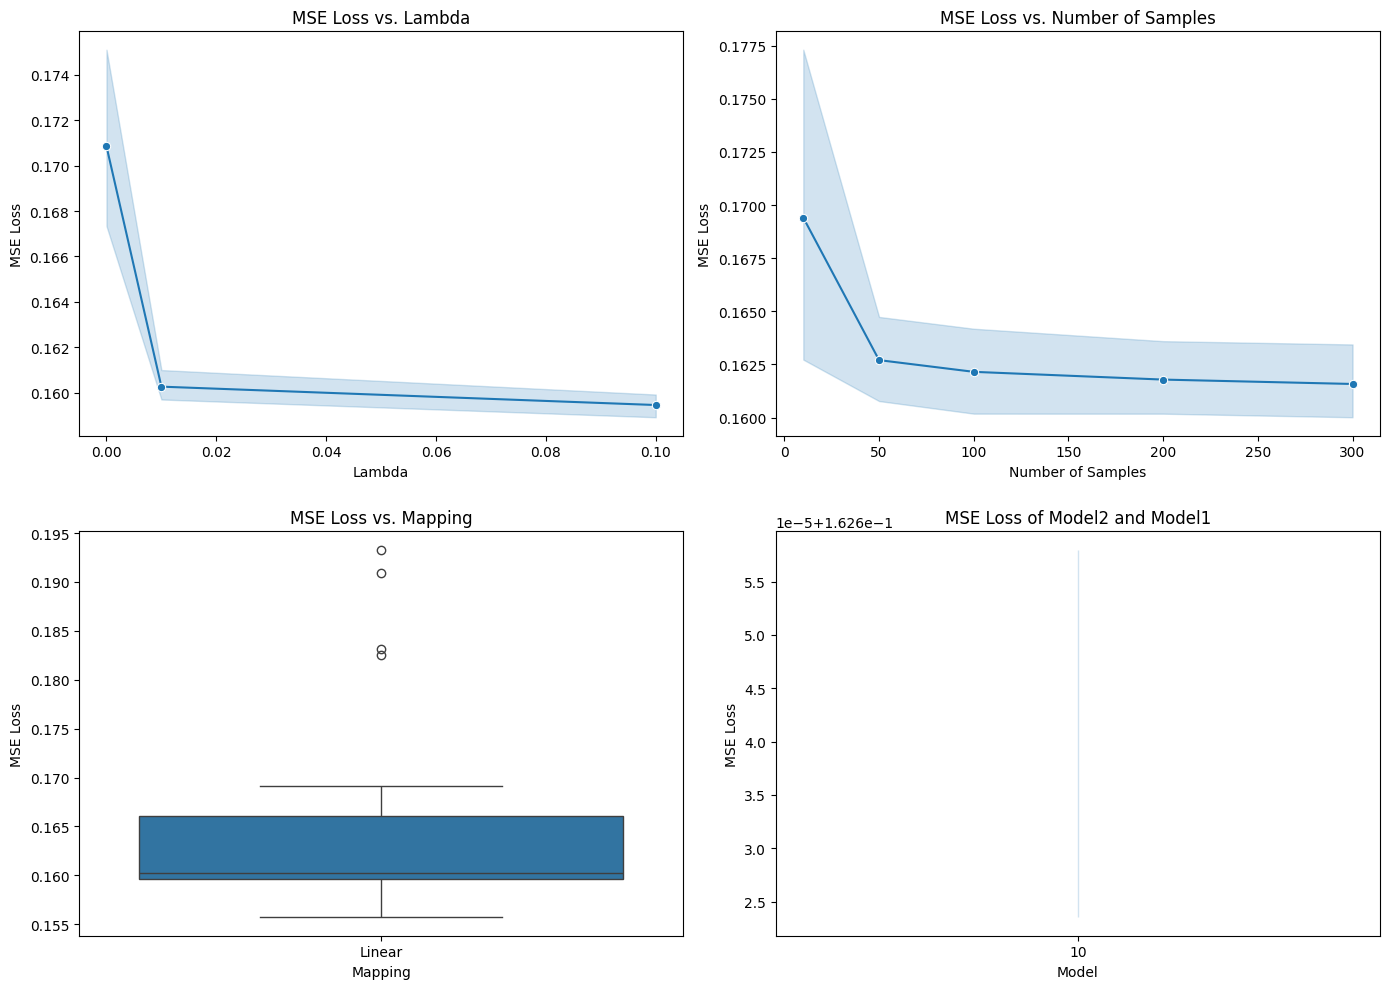

In [6]:
# Plotting
plt.figure(figsize=(14, 10))

# Plot MSE_loss vs. lambda
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='lambda', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='num_samples', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. latent dimension
plt.subplot(2, 2, 4)
# Change opacity of the boxplot
temp_res = results.copy()

# Function to safely extract the third part
def extract_third_part(s):
    parts = s.split('_')
    print(parts)
    if len(parts) >= 3:
        return parts[2]
    else:
        return None  # Or any default value you prefer

temp_res['latent_dim'] = temp_res['model2'].apply(extract_third_part)


sns.lineplot(data=temp_res, x='latent_dim', y='MSE_loss_model2')

plt.title('MSE Loss of Model2 and Model1')
plt.xlabel('Model')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

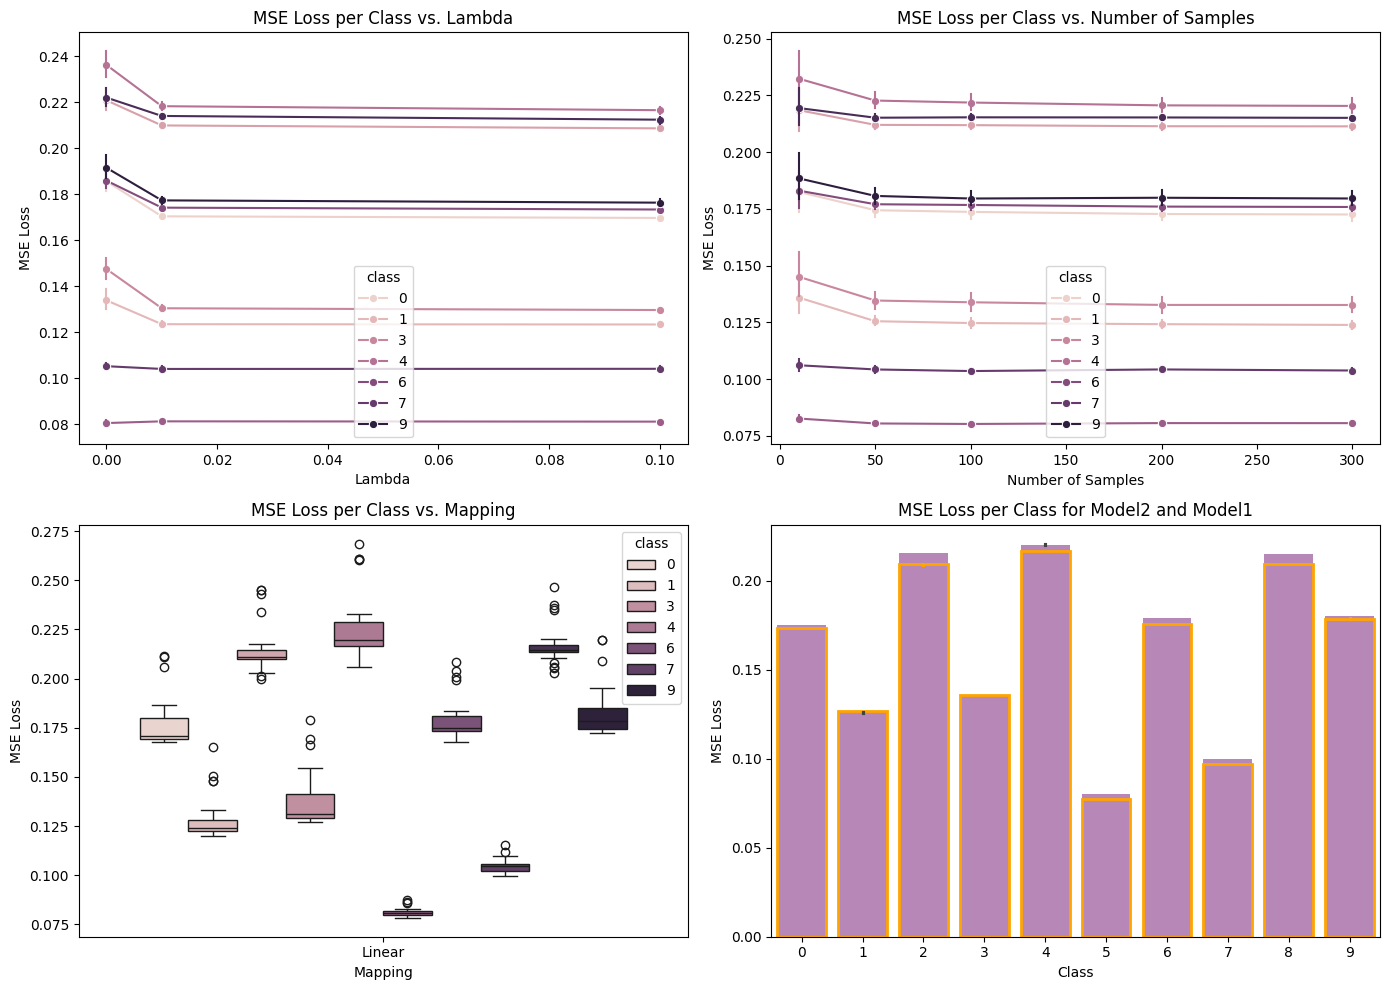

In [7]:
# Use different colors for each class blue

#sns.set_palette(sns.color_palette("tab10"))

# Plot MSE_loss per class vs. lambda
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=results_class, x='lambda', y='MSE_loss', marker='o', hue='class', err_style='bars')
# Make Variance of the lineplot not visible


plt.title('MSE Loss per Class vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results_class, x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')
plt.title('MSE Loss per Class vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. mapping
plt.subplot(2, 2, 3)
sns.boxplot(data=results_class, x='mapping', y='MSE_loss', hue='class')
plt.title('MSE Loss per Class vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot class outliers for each class 
plt.subplot(2, 2, 4)
sns.barplot(data=results_class, x='class', y='MSE_loss_model2', color='purple', alpha=0.5)
sns.barplot(data=results_class, x='class', y='MSE_loss_model1', color='orange', fill=None, linewidth=2)

plt.title('MSE Loss per Class for Model2 and Model1')
plt.xlabel('Class')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

              lambda   num_samples  reconstruction_error_model1  \
count  600000.000000  600000.00000                600000.000000   
mean        0.036667     132.00000                     0.242352   
std         0.044969     105.33764                     0.096066   
min         0.000000      10.00000                     0.030700   
25%         0.000000      50.00000                     0.168820   
50%         0.010000     100.00000                     0.232001   
75%         0.100000     200.00000                     0.314650   
max         0.100000     300.00000                     0.620569   

       reconstruction_error_model2  reconstruction_error_stitched  \
count                600000.000000                  600000.000000   
mean                      0.245996                       0.245805   
std                       0.098562                       0.099398   
min                       0.030688                       0.030870   
25%                       0.171304                 

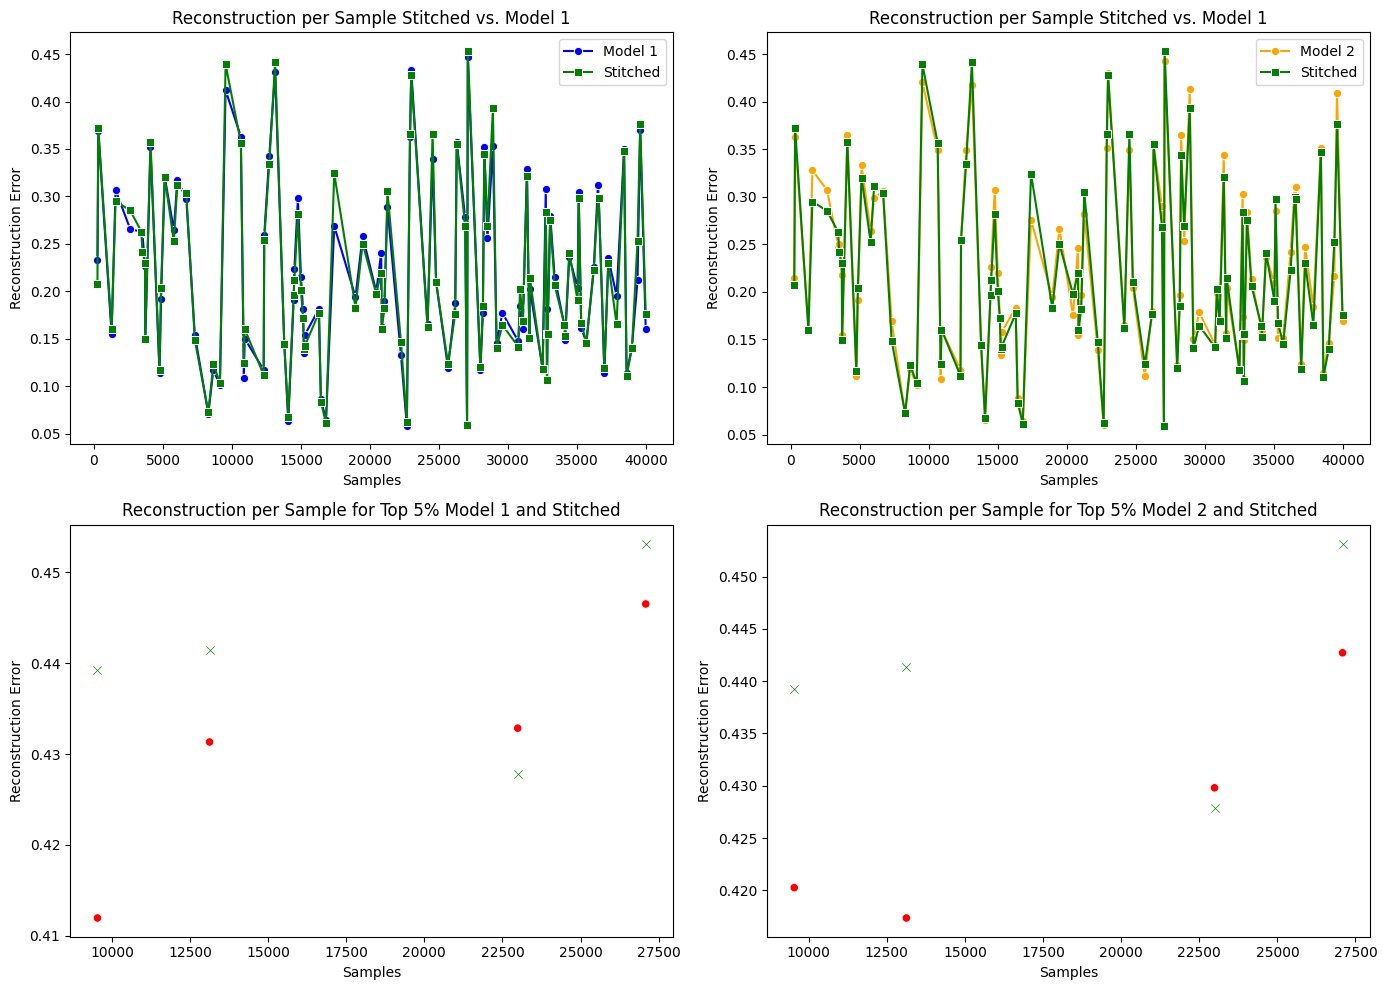

In [8]:
################################################
filter = {
    "model1": "models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE_10_2.pth",
    "model2": "models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE_10_1.pth",
    "mapping": "Linear",
    "lambda": 0.01,
    "num_samples": 100,
    "dataset": "FMNIST"
}
################################################

print(results_top.describe())

# Get results top for the filter
results_top_filtered = results_top[(results_top["model1"] == filter["model1"]) & (results_top["model2"] == filter["model2"]) & (results_top["mapping"] == filter["mapping"]) & (results_top["lambda"] == filter["lambda"]) & (results_top["num_samples"] == filter["num_samples"]) & (results_top["dataset"] == filter["dataset"])]

# Add a new column for the x-axis index
results_top_filtered = results_top_filtered.reset_index(drop=True)
results_top_filtered['index'] = results_top_filtered.index + 1

print(results_top_filtered)
# Random indices for sampling
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(results_top_filtered.index, 100, replace=False)

# Take only the random indices
results_top_filtered_sampled = results_top_filtered.loc[random_indices]

# Plot the reconstruction error 
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_model1', marker='o', color='blue', label='Model 1')
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Reconstruction per Sample Stitched vs. Model 1')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.legend()

plt.subplot(2, 2, 2)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_model2', marker='o', color='orange', label='Model 2')
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Reconstruction per Sample Stitched vs. Model 1')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.legend()

# Get indices of the top 5% of each model
top_indices_model1 = results_top_filtered_sampled[results_top_filtered_sampled["model1_top"] == True]
top_indices_model2 = results_top_filtered_sampled[results_top_filtered_sampled["model2_top"] == True]
top_indices_stitched = results_top_filtered_sampled[results_top_filtered_sampled["stitched_top"] == True]

# Convert the indices to numpy arrays
top_indices_model1_array = top_indices_model1.index.to_numpy()
top_indices_model2_array = top_indices_model2.index.to_numpy()
top_indices_stitched_array = top_indices_stitched.index.to_numpy()

# Intersection of all the top indices that are in the top 5% of all models
intersection_top = np.intersect1d(top_indices_model1_array, top_indices_stitched_array)
intersection_top_mod2 = np.intersect1d(top_indices_model2_array, top_indices_model2_array)

# Add color column to DataFrame
results_top_filtered['color_model1'] = 'blue'
results_top_filtered.loc[intersection_top, 'color_model1'] = 'red'
results_top_filtered['color_model2'] = 'blue'
results_top_filtered.loc[intersection_top_mod2, 'color_model2'] = 'red'



plt.subplot(2, 2, 3)
# Use as x the index of the datapoints
sns.scatterplot(data=results_top_filtered.loc[top_indices_model1_array], x='index', y='reconstruction_error_model1', hue='color_model1', palette={'blue': 'blue', 'red': 'red'}, legend=False)
sns.scatterplot(data=results_top_filtered.loc[top_indices_stitched_array], x='index', y='reconstruction_error_stitched', marker='x', color='green', legend=False)
plt.title('Reconstruction per Sample for Top 5% Model 1 and Stitched')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')

plt.subplot(2, 2, 4)
# Use as x the index of the datapoints
sns.scatterplot(data=results_top_filtered.loc[top_indices_model2_array], x='index', y='reconstruction_error_model2', hue='color_model2', palette={'blue': 'blue', 'red': 'red'}, legend=False)
sns.scatterplot(data=results_top_filtered.loc[top_indices_stitched_array], x='index', y='reconstruction_error_stitched', marker='x', color='green', legend=False)
plt.title('Reconstruction per Sample for Top 5% Model 2 and Stitched')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')

plt.tight_layout()
plt.show()






/var/folders/tp/9l7ncvh137x08kdlp_fvr1nw0000gn/T/ipykernel_54702/2828233266.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/tp/9l7ncvh137x08kdlp_fvr1nw0000gn/T/ipykernel_54702/2828233266.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/tp/9l7ncvh137x08kdlp_fvr1nw0000gn/T/ipykernel_54702/2828233266.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


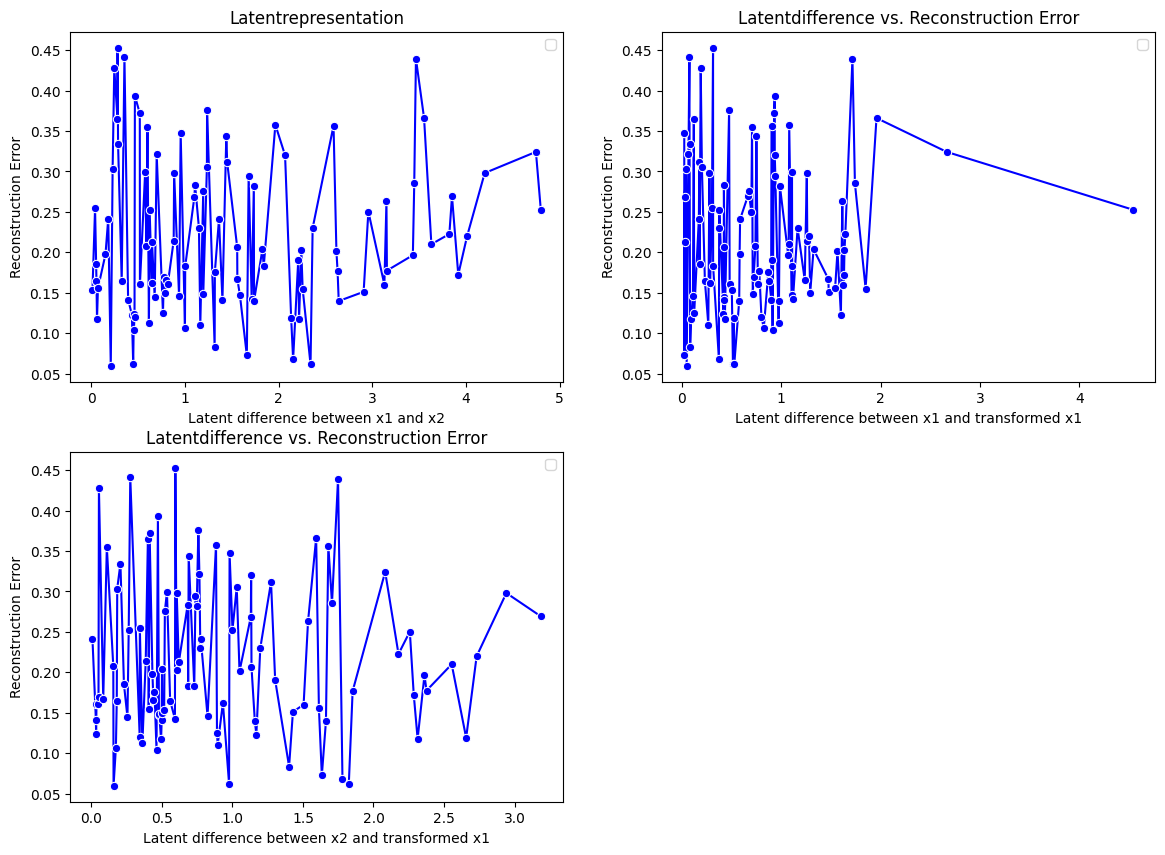

In [9]:
# Plot the influence on the latent space 
results_top_filtered_sampled = results_top_filtered_sampled


# Plot the reconstruction error 
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_original', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentrepresentation')
plt.xlabel('Latent difference between x1 and x2')
plt.ylabel('Reconstruction Error')
plt.legend()

plt.subplot(2, 2, 2)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_mod1', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentdifference vs. Reconstruction Error')
plt.xlabel('Latent difference between x1 and transformed x1')
plt.ylabel('Reconstruction Error')
plt.legend()

# 
plt.subplot(2, 2, 3)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_mod2', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentdifference vs. Reconstruction Error')
plt.xlabel('Latent difference between x2 and transformed x1')
plt.ylabel('Reconstruction Error')
plt.legend()


# Reconstruction error for the worse 5% of the model






<Axes: title={'center': 'MSE Loss per Class vs. num samples, outliers sampling strategy'}, xlabel='num_samples', ylabel='MSE Loss'>

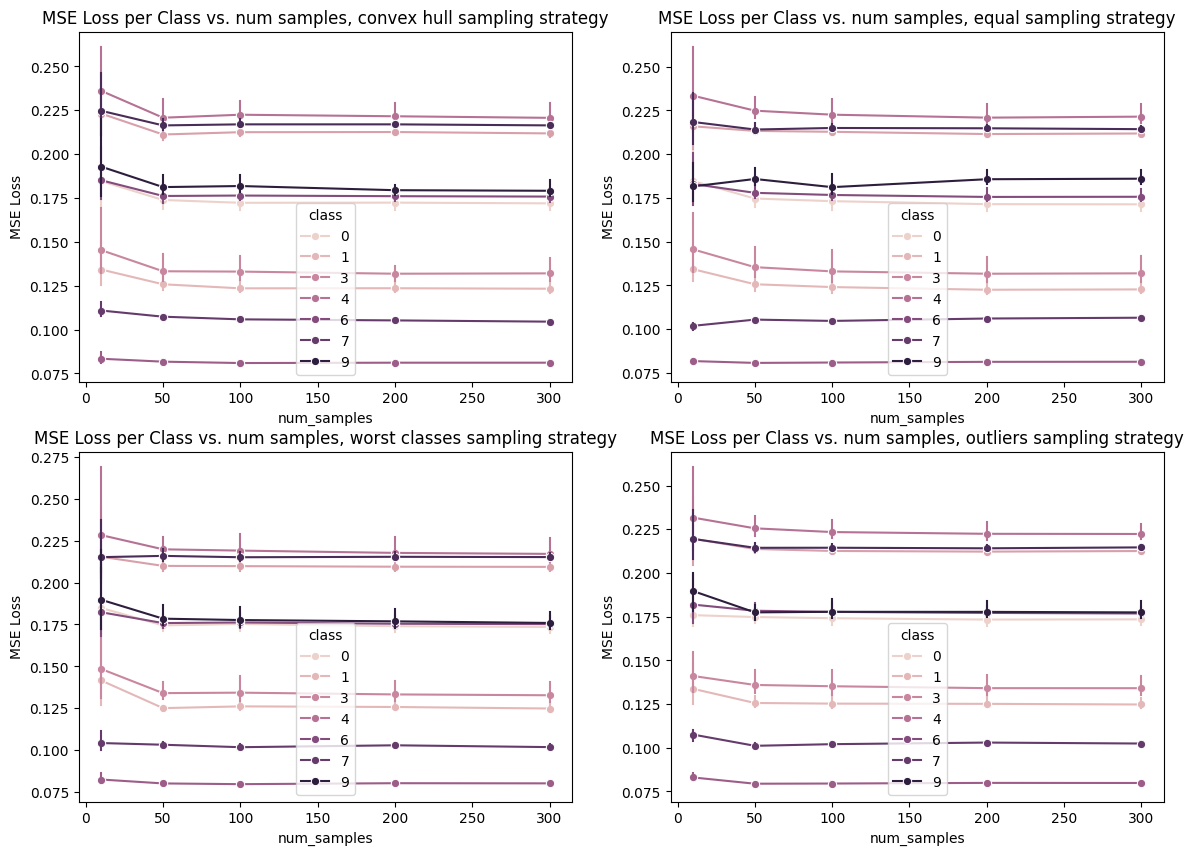

In [10]:
results_top = pd.read_csv("results_top.csv")

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.title('MSE Loss per Class vs. num samples, convex hull sampling strategy')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')
sns.lineplot(data=results_class[results_class['sampling_strategy'] == 'equally'], x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')

# Plot MSE_loss per class vs. num_samples
plt.subplot(2, 2, 2)
plt.title('MSE Loss per Class vs. num samples, equal sampling strategy')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')
sns.lineplot(data=results_class[results_class['sampling_strategy'] == 'convex_hull'], x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')

plt.subplot(2, 2, 3)
plt.title('MSE Loss per Class vs. num samples, worst classes sampling strategy')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')
sns.lineplot(data=results_class[results_class['sampling_strategy'] == 'worst_classes'], x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')

plt.subplot(2, 2, 4)
plt.title('MSE Loss per Class vs. num samples, outliers sampling strategy')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')
sns.lineplot(data=results_class[results_class['sampling_strategy'] == 'outliers'], x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')

In [1]:
from scipy.stats import norm

# Load the data
error_distribution = pd.read_csv("error_distribution.csv")
error_distribution['class'] = error_distribution['class'].astype(int)

# Calculate the mean of the means and variances
absolute_variance = error_distribution['variance'].mean()
absolute_mean = error_distribution['mean'].mean()

# Generate points for plotting
points = np.linspace(absolute_mean - 3 * np.sqrt(absolute_variance), 
                     absolute_mean + 3 * np.sqrt(absolute_variance), 100)

# Define function to get y-values for the normal distribution based on each row
def get_points_y(row):
    mean = row['mean']
    variance = row['variance']
    return norm.pdf(points, mean, np.sqrt(variance))

# Apply the function to each row to get the distribution
error_distribution['distribution'] = error_distribution.apply(get_points_y, axis=1)

# Prepare data for plotting
plot_data = pd.DataFrame()
for idx, row in error_distribution.iterrows():
    temp_df = pd.DataFrame({
        'x': points,
        'y': row['distribution'],
        'class': row['class']
    })
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Plot using Seaborn
plt.figure(figsize=(14, 10))
plt.title('Loss distribution per class, over all models')
plt.xlabel('Mse Loss')
plt.ylabel('Frequency')

num_classes = len(error_distribution['class'].unique())
palette = sns.color_palette("husl", num_classes)

sns.lineplot(data=plot_data, x='x', y='y', hue='class', palette=palette)


plt.show()

SyntaxError: invalid syntax (2379177687.py, line 19)